### - PCA and Clustering  for L1000 Level-4 profiles (per dose treament)

#### - Use Silhouette and Davies Bouldin scores to assess the number of clusters from K-Means
#### - Use BIC scores to assess the number of clusters from Gaussian Mixture Models (GMM)

[reference](https://sites.northwestern.edu/msia/2016/12/08/k-means-shouldnt-be-our-only-choice/)
[refeerences](https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/)

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc

from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture as GMM
import os
import pandas as pd
import numpy as np
import re
from os import walk
from collections import Counter
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
##sns.set_palette(["red", "green", "orange","blue","gray","purple"])
sns.set_context("talk")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
L1000_level4_path = "../1.Data-exploration/Profiles_level4/L1000/L1000_lvl4_cpd_replicate_datasets"

In [3]:
df_level4 = pd.read_csv(os.path.join(L1000_level4_path, 'L1000_level4_cpd_replicates.csv.gz'), 
                        compression='gzip',low_memory = False)

In [4]:
df_level4.shape

(27837, 988)

In [5]:
df_level4.shape

(27837, 988)

In [6]:
df_level4['dose'].unique()

array([0, 6, 5, 4, 3, 2, 1, 7])

In [7]:
def extract_dose_df(df, dose_num):
    """Extract data for each treatment dose"""
    df_dose = df[df['dose'] == dose_num].reset_index(drop=True)
    metadata_cols = ['replicate_id', 'sig_id', 'pert_id', 'pert_idose', 'det_plate', 
                     'det_well', 'dose', 'Metadata_broad_sample', 'moa', 'pert_iname']
    df_dose.drop(metadata_cols, axis = 1, inplace = True)
    return df_dose

In [8]:
def transform_pca(df, dose_num, no_of_pcs =350):
    """Perform PCA Analysis"""
    scaler = StandardScaler()
    scaled_agg = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(data = scaled_agg, columns = ['feat_' + str(x) for x in range(1,df.shape[1]+1)])
    #lets extract features with the most variance in our dataset
    pca = PCA(n_components=no_of_pcs)
    pc = pca.fit_transform(scaled_agg)
    df_pc = pd.DataFrame(data = pc, columns = ['PC' + str(x) for x in range(1,no_of_pcs+1)])
    df_pc['dose'] = dose_num
    
    #Plotting the Cumulative Summation of the Explained Variance
    plt.figure(figsize=(16, 8))
    fig = plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Principal Components')
    plt.xticks(np.arange(0, no_of_pcs+1, step=20))
    plt.show()
    
    return pca, df_pc, df_scaled

In [9]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [10]:
def calc_bic(pc_data, no_of_clusters=40):
    """
    Computes Bayesian Information Criteria scores (BIC) when Gaussian Mixture Models (GMM) is fitted on a data
    to assess the clustering on the data
    """
    n_clusters=np.arange(2, no_of_clusters+1)
    bics=[]
    bics_err=[]
    iterations=1
    for n in n_clusters:
        #print(n)
        tmp_bic=[]
        for _ in range(iterations):
            gmm=GMM(n, n_init=2, max_iter=1000,
                    tol=1e-4,init_params='kmeans').fit(pc_data)
            tmp_bic.append(gmm.bic(pc_data))
        val=np.mean(SelBest(np.array(tmp_bic), int(iterations/1)))
        err=np.std(tmp_bic)
        bics.append(val)
        bics_err.append(err)
    return bics, bics_err

In [11]:
def plot_bics(bics):
    plt.figure(figsize=(14,6))
    plt.plot(list(bics.keys()), list(bics.values()), label='BIC')
    plt.title("BIC Scores", fontsize=20)
    plt.xlabel("N. of clusters")
    plt.ylabel("Score")
    plt.legend()

In [12]:
def calculate_score(df, no_of_clusters=40):
    """
    Assess K-means clustering using Silhoutte and Davies bouldin scores
    """
    silh_score = {}
    davie_score = {}
    for k in range(2, no_of_clusters+1):
        kmeans = KMeans(n_clusters=k, 
                        max_iter=1000, 
                        tol=1e-4)
        label = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, label)
        davie_avg = davies_bouldin_score(df,label)
        silh_score[k] = silhouette_avg
        davie_score[k] = davie_avg
        #print("For n_clusters={}, The average silhouette_score is: {}".format(k, silhouette_avg))
        #print("For n_clusters={}, The davies_bouldin_score is: {}".format(k, davie_avg))
        
    return silh_score, davie_score

In [13]:
def plot_score(score, score_name):
    
    plt.rcParams.update({'font.size': 12})
    plt.figure(figsize=(12, 6))
    plt.plot(list(score.keys()), list(score.values()), 
             linestyle='--', marker='o', color='orange')
    plt.title(f"{score_name} across clusters", fontsize=20)
    plt.xlabel("Number of clusters")
    plt.ylabel(score_name)
    plt.xticks(np.arange(0, max(list(score.keys()))+1, step=2))
    plt.show()

In [14]:
def create_df(data_dict, col_name, dose_num):
    df = pd.DataFrame(data_dict.items(), columns = ['cluster', col_name]) 
    df['dose'] = dose_num
    return df

### - Dose 1

In [15]:
df_dose_1 = extract_dose_df(df_level4, dose_num=1)

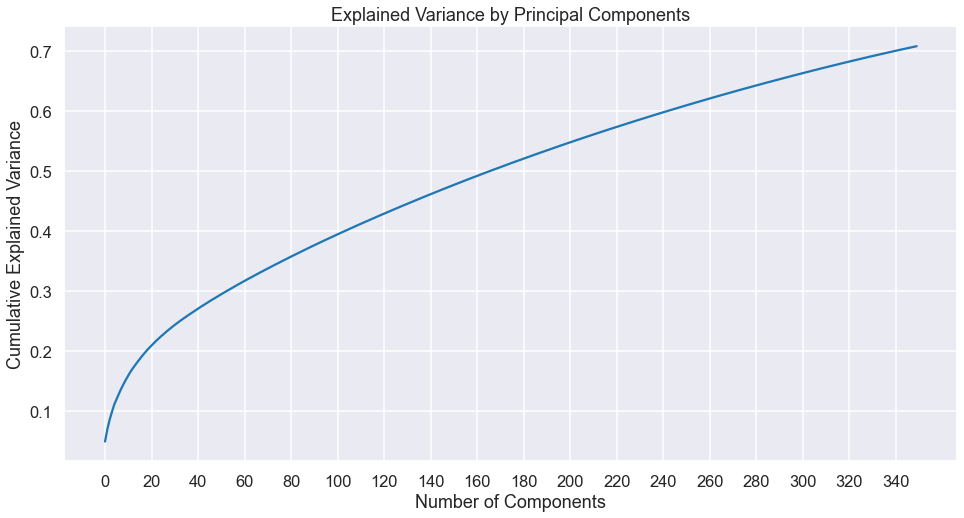

In [16]:
pca_dose1, df_pc_dose1, df_scaled_dose1 = transform_pca(df_dose_1, dose_num=1)

In [17]:
np.sum(pca_dose1.explained_variance_ratio_) ##350 pcs explain ~70 variance in CP data

0.7077074583947528

In [18]:
bics_dose1, _ = calc_bic(df_pc_dose1.drop(['dose'], axis = 1))

In [19]:
dose1_bic_score = {idx+2:score for idx, score in enumerate(bics_dose1)}

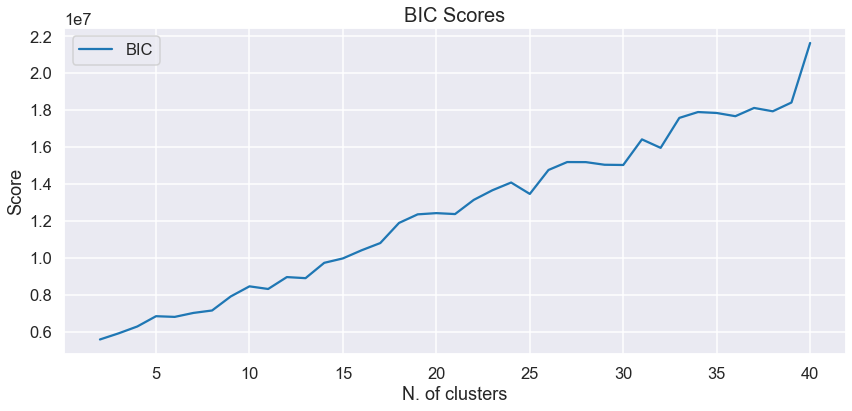

In [20]:
plot_bics(dose1_bic_score)

In [21]:
dose1_silh_score, dose1_davie_score = calculate_score(df_pc_dose1.drop(['dose'], axis = 1))

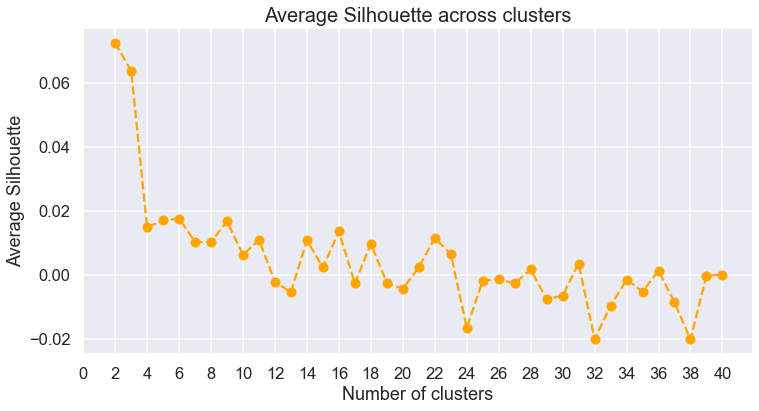

In [22]:
plot_score(dose1_silh_score, 'Average Silhouette')

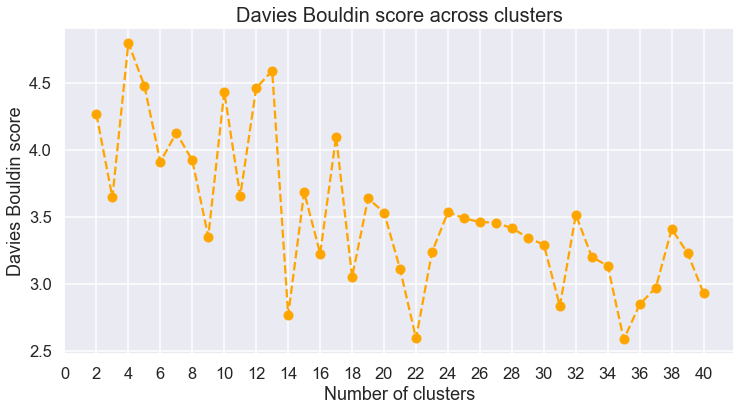

In [23]:
plot_score(dose1_davie_score, 'Davies Bouldin score')

In [24]:
df_silh1 = create_df(dose1_silh_score, 'Average_silhouette_score', 1)
df_db1 = create_df(dose1_davie_score, 'davies_bouldin_score', 1)
df_bic1 = create_df(dose1_bic_score, 'BIC_score', 1)

###  - Dose 2

In [25]:
df_dose_2 = extract_dose_df(df_level4, dose_num=2)

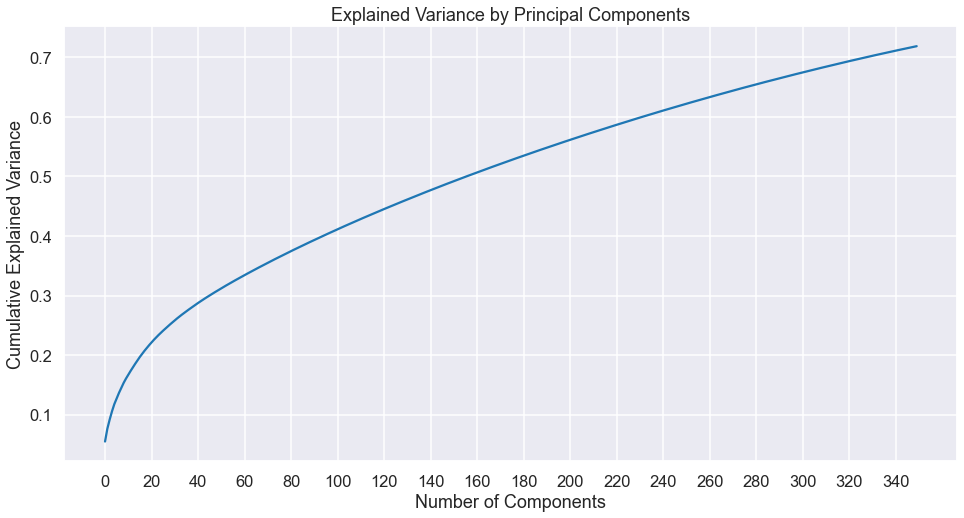

In [26]:
pca_dose2, df_pc_dose2, df_scaled_dose2 = transform_pca(df_dose_2, dose_num=2)

In [27]:
np.sum(pca_dose2.explained_variance_ratio_) ##350 pcs explain ~71% variance in CP data

0.7188044933783359

In [28]:
bics_dose2, _ = calc_bic(df_pc_dose2.drop(['dose'], axis = 1))

In [29]:
dose2_bic_score = {idx+2:score for idx, score in enumerate(bics_dose2)}

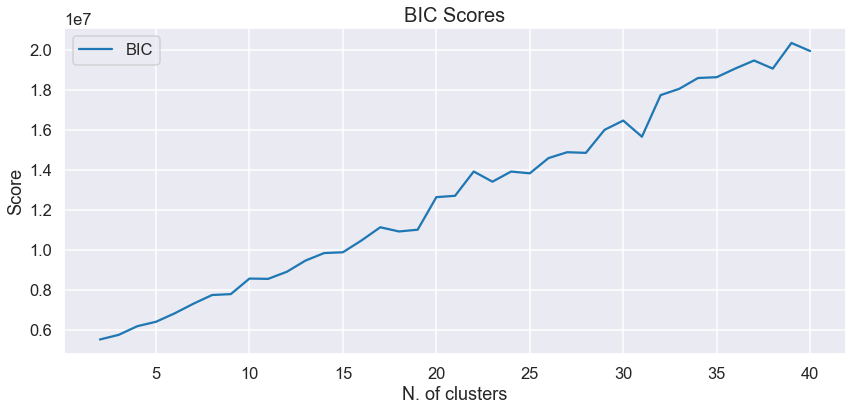

In [30]:
plot_bics(dose2_bic_score)

In [31]:
dose2_silh_score, dose2_davie_score = calculate_score(df_pc_dose2.drop(['dose'], axis = 1))

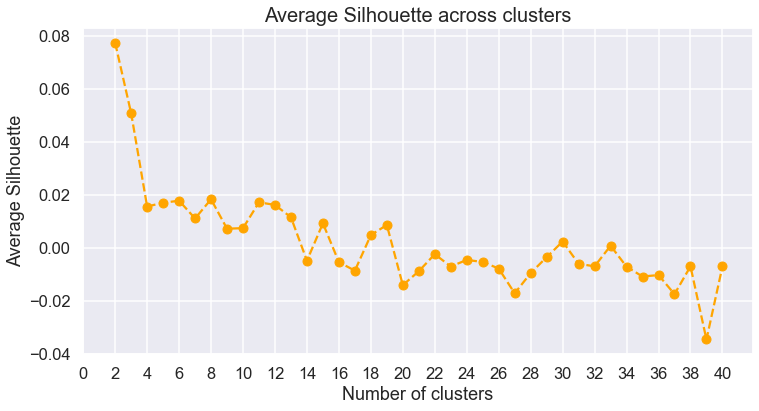

In [32]:
plot_score(dose2_silh_score, 'Average Silhouette')

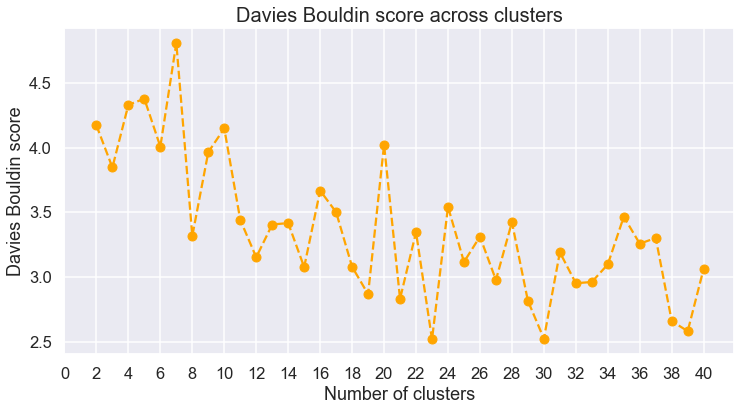

In [33]:
plot_score(dose2_davie_score, 'Davies Bouldin score')

In [34]:
df_silh2 = create_df(dose2_silh_score, 'Average_silhouette_score', 2)
df_db2 = create_df(dose2_davie_score, 'davies_bouldin_score', 2)
df_bic2 = create_df(dose2_bic_score, 'BIC_score', 2)

### - Dose 3

In [35]:
df_dose_3 = extract_dose_df(df_level4, dose_num=3)

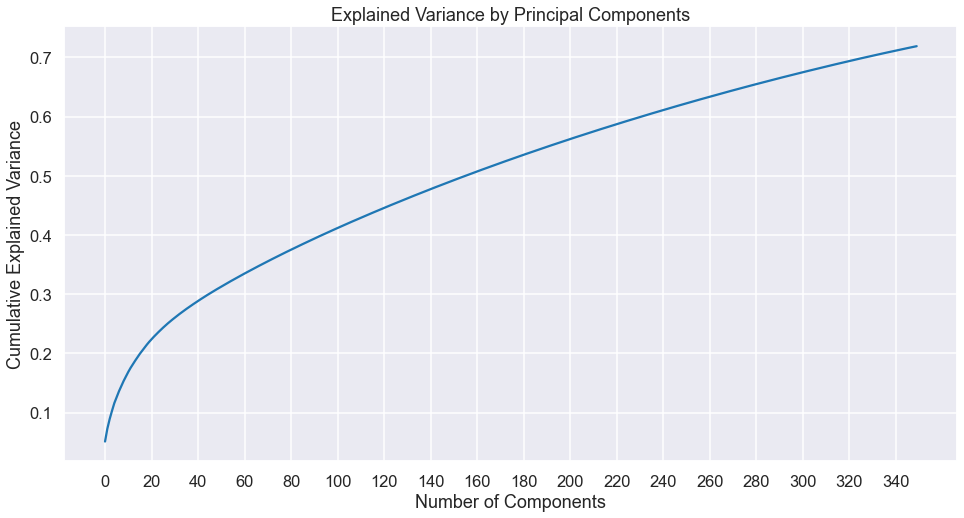

In [36]:
pca_dose3, df_pc_dose3, df_scaled_dose3 = transform_pca(df_dose_3, dose_num=3)

In [37]:
np.sum(pca_dose3.explained_variance_ratio_) ##350 pcs explain ~71% variance in CP data

0.7188459650842943

In [38]:
bics_dose3, _ = calc_bic(df_pc_dose3.drop(['dose'], axis = 1))

In [39]:
dose3_bic_score = {idx+2:score for idx, score in enumerate(bics_dose3)}

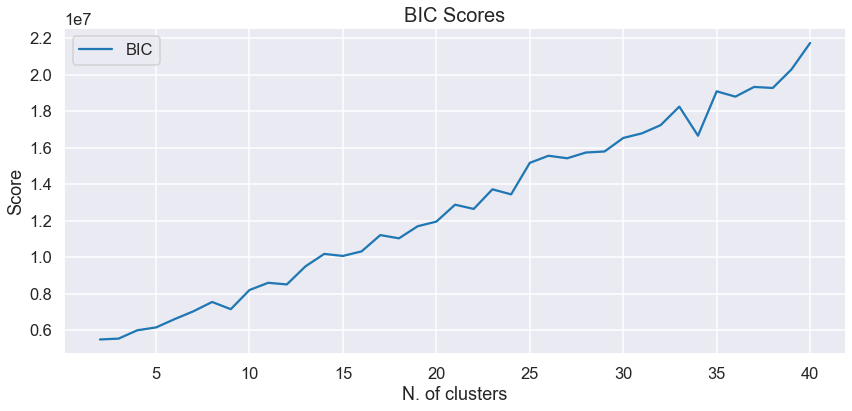

In [40]:
plot_bics(dose3_bic_score)

In [41]:
dose3_silh_score, dose3_davie_score = calculate_score(df_pc_dose3.drop(['dose'], axis = 1))

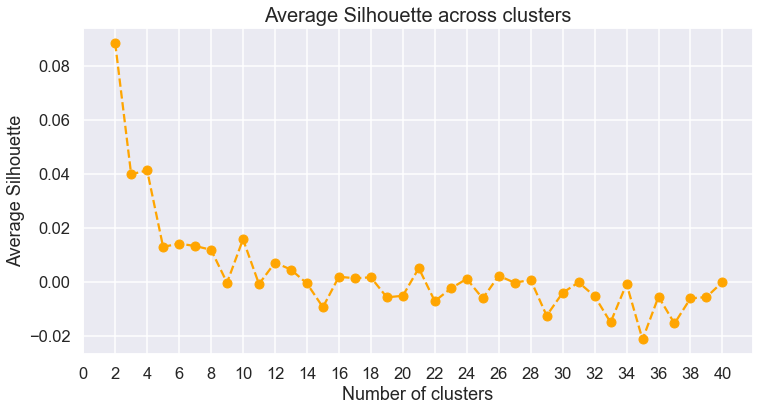

In [42]:
plot_score(dose3_silh_score, 'Average Silhouette')

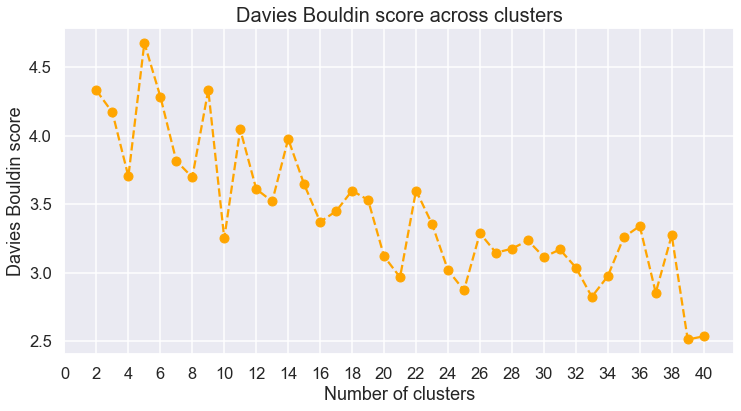

In [43]:
plot_score(dose3_davie_score, 'Davies Bouldin score')

In [44]:
df_silh3 = create_df(dose3_silh_score, 'Average_silhouette_score', 3)
df_db3 = create_df(dose3_davie_score, 'davies_bouldin_score', 3)
df_bic3 = create_df(dose3_bic_score, 'BIC_score', 3)

### - Dose 4

In [45]:
df_dose_4 = extract_dose_df(df_level4, dose_num=4)

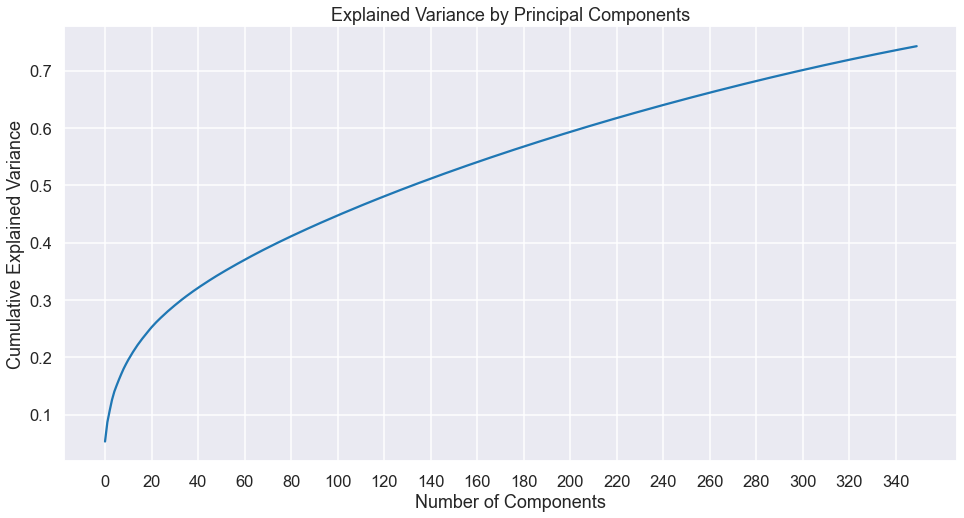

In [46]:
pca_dose4, df_pc_dose4, df_scaled_dose4 = transform_pca(df_dose_4, dose_num=4)

In [47]:
np.sum(pca_dose4.explained_variance_ratio_) ##350 pcs explain ~74% variance in CP data

0.7426010272764503

In [48]:
bics_dose4, _ = calc_bic(df_pc_dose4.drop(['dose'], axis = 1))

In [49]:
dose4_bic_score = {idx+2:score for idx, score in enumerate(bics_dose4)}

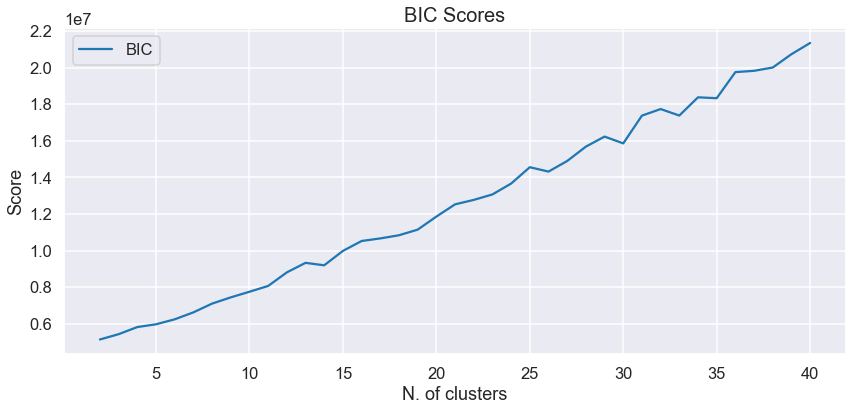

In [50]:
plot_bics(dose4_bic_score)

In [51]:
dose4_silh_score, dose4_davie_score = calculate_score(df_pc_dose4.drop(['dose'], axis = 1))

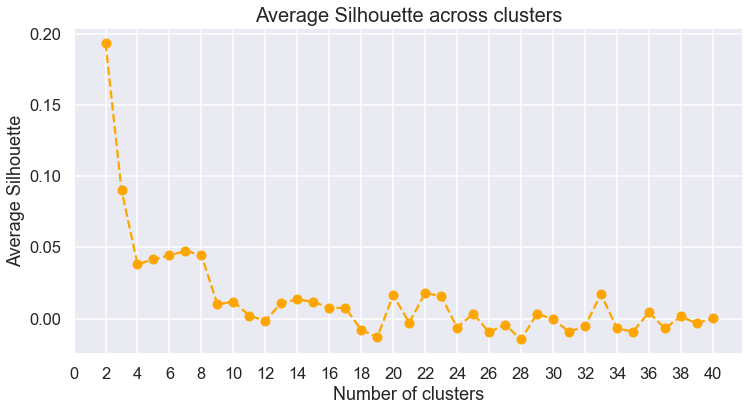

In [52]:
plot_score(dose4_silh_score, 'Average Silhouette')

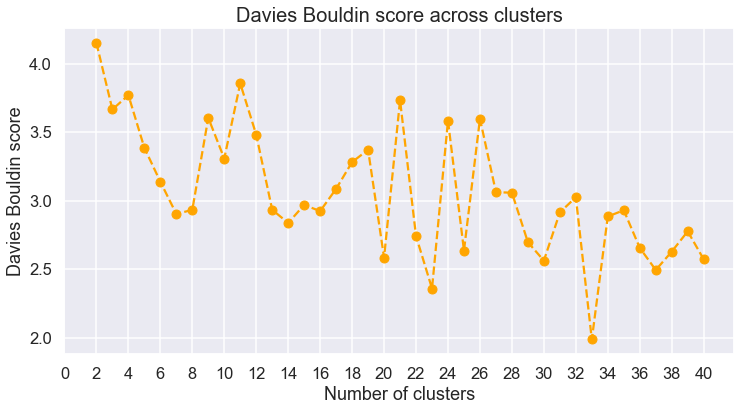

In [53]:
plot_score(dose4_davie_score, 'Davies Bouldin score')

In [54]:
df_silh4 = create_df(dose4_silh_score, 'Average_silhouette_score', 4)
df_db4 = create_df(dose4_davie_score, 'davies_bouldin_score', 4)
df_bic4 = create_df(dose4_bic_score, 'BIC_score', 4)

### - Dose 5

In [55]:
df_dose_5 = extract_dose_df(df_level4, dose_num=5)

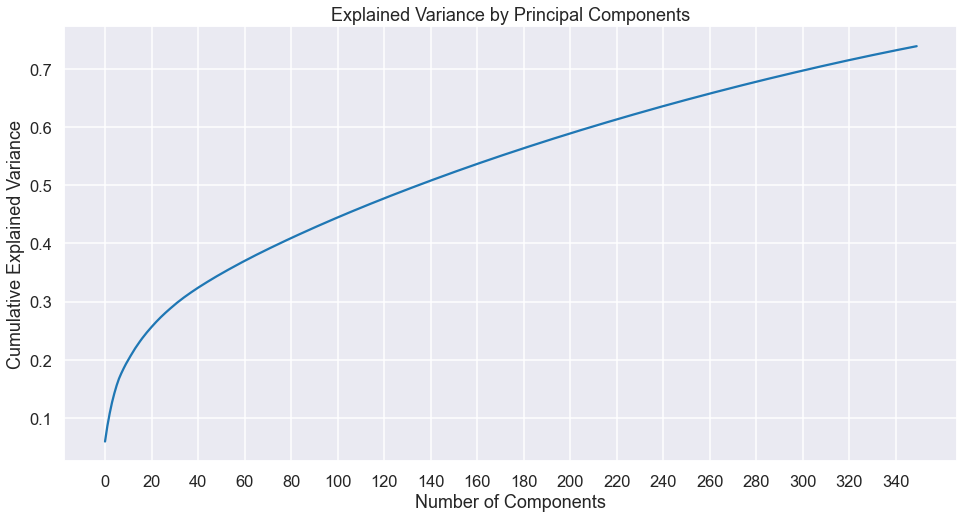

In [56]:
pca_dose5, df_pc_dose5, df_scaled_dose5 = transform_pca(df_dose_5, dose_num=5)

In [57]:
np.sum(pca_dose5.explained_variance_ratio_) ##350 pcs explain ~74% variance in CP data

0.7387269922074108

In [58]:
bics_dose5, _ = calc_bic(df_pc_dose5.drop(['dose'], axis = 1))

In [59]:
dose5_bic_score = {idx+2:score for idx, score in enumerate(bics_dose5)}

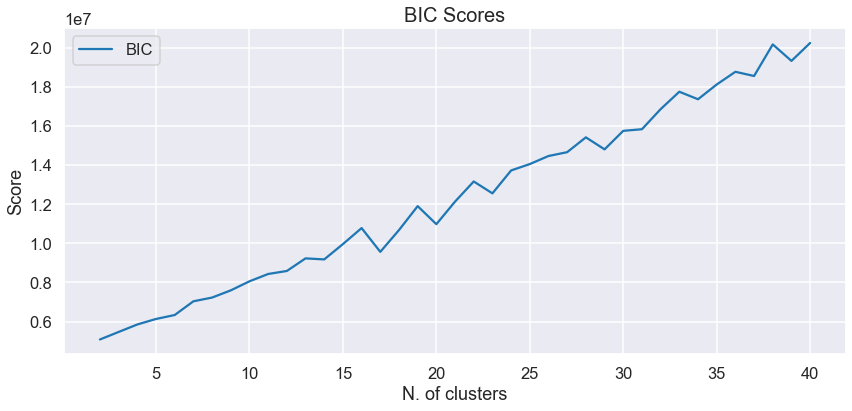

In [60]:
plot_bics(dose5_bic_score)

In [61]:
dose5_silh_score, dose5_davie_score = calculate_score(df_pc_dose5.drop(['dose'], axis = 1))

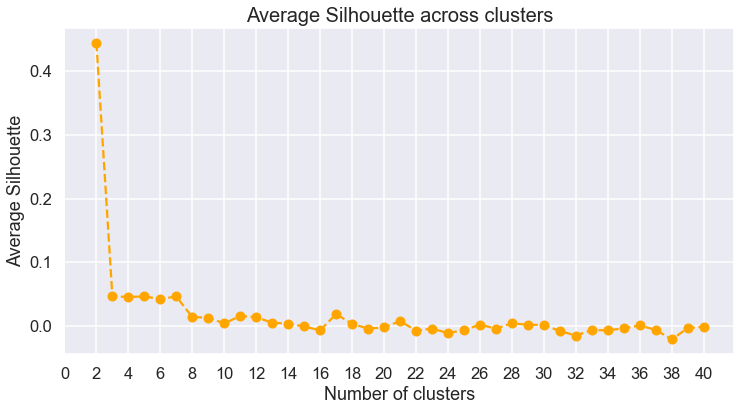

In [62]:
plot_score(dose5_silh_score, 'Average Silhouette')

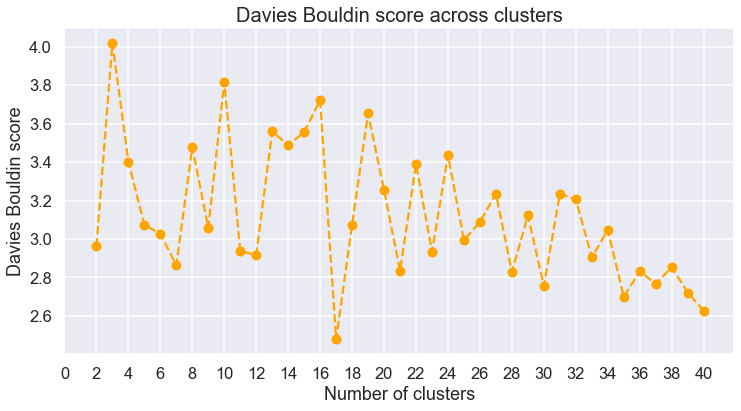

In [63]:
plot_score(dose5_davie_score, 'Davies Bouldin score')

In [64]:
df_silh5 = create_df(dose5_silh_score, 'Average_silhouette_score', 5)
df_db5 = create_df(dose5_davie_score, 'davies_bouldin_score', 5)
df_bic5 = create_df(dose5_bic_score, 'BIC_score', 5)

### - Dose 6

In [65]:
df_dose_6 = extract_dose_df(df_level4, dose_num=6)

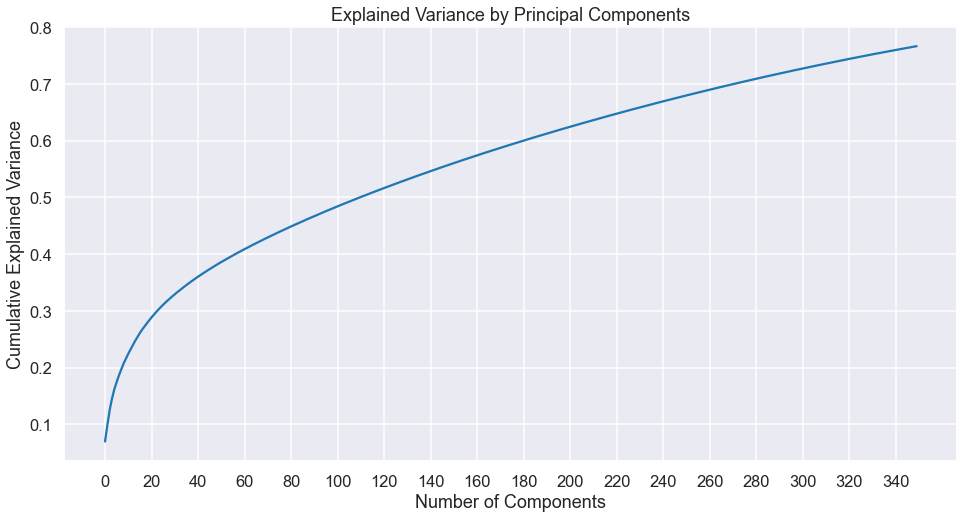

In [66]:
pca_dose6, df_pc_dose6, df_scaled_dose6 = transform_pca(df_dose_6, dose_num=6)

In [67]:
np.sum(pca_dose6.explained_variance_ratio_) ##350 pcs explain ~76% variance in CP data

0.7663291946575743

In [68]:
bics_dose6, _ = calc_bic(df_pc_dose6.drop(['dose'], axis = 1))

In [69]:
dose6_bic_score = {idx+2:score for idx, score in enumerate(bics_dose6)}

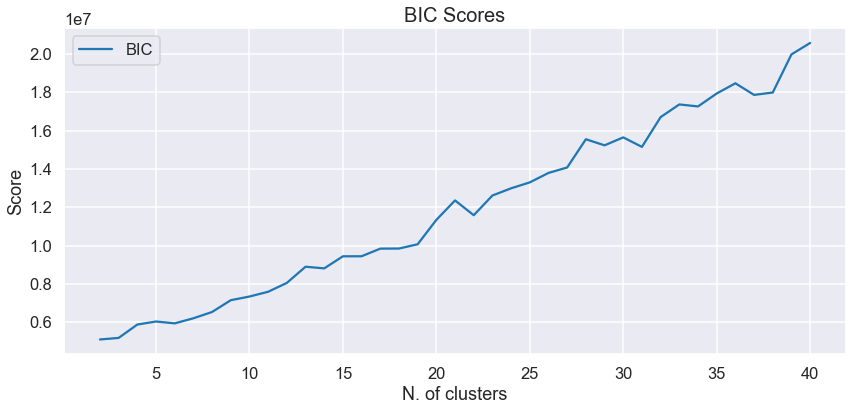

In [70]:
plot_bics(dose6_bic_score)

In [71]:
dose6_silh_score, dose6_davie_score = calculate_score(df_pc_dose6.drop(['dose'], axis = 1))

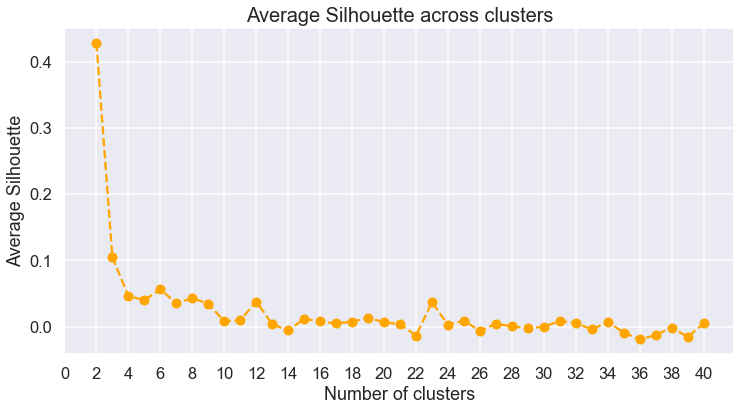

In [72]:
plot_score(dose6_silh_score, 'Average Silhouette')

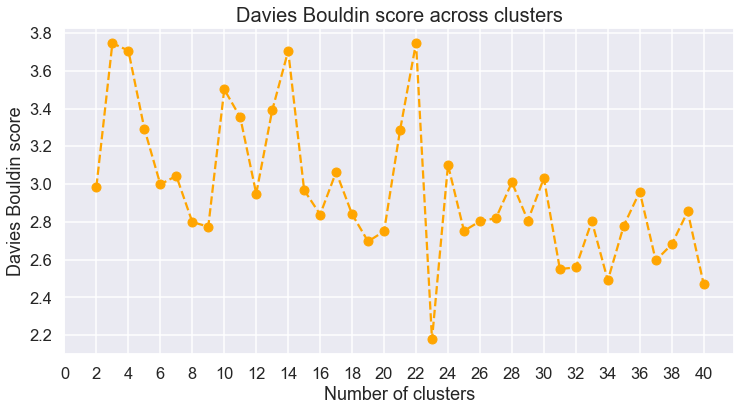

In [73]:
plot_score(dose6_davie_score, 'Davies Bouldin score')

In [74]:
df_silh6 = create_df(dose6_silh_score, 'Average_silhouette_score', 6)
df_db6 = create_df(dose6_davie_score, 'davies_bouldin_score', 6)
df_bic6 = create_df(dose6_bic_score, 'BIC_score', 6)

### - All doses

In [75]:
df_lvl4_new = df_level4[df_level4['pert_iname'] != 'DMSO'].reset_index(drop=True)

In [76]:
metadata_cols = ['replicate_id', 'sig_id', 'pert_id', 'pert_idose', 'det_plate',
                 'det_well', 'dose', 'Metadata_broad_sample', 'moa', 'pert_iname']

df_alldose = df_lvl4_new.drop(metadata_cols, axis = 1)

In [77]:
df_alldose.shape

(26352, 978)

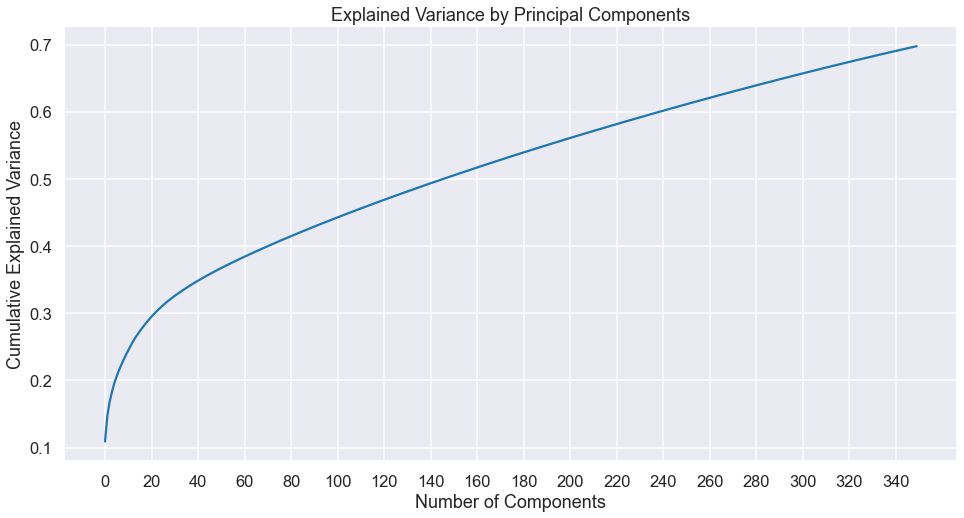

In [78]:
pca_all, df_pc_all, df_scaled_all = transform_pca(df_alldose, None)

In [79]:
np.sum(pca_all.explained_variance_ratio_)

0.6975035783674539

In [80]:
doseall_silh_score, doseall_davie_score = calculate_score(df_pc_all.drop(['dose'], axis = 1))

In [81]:
df_silhall = create_df(doseall_silh_score, 'Average_silhouette_score', "all")
df_dball = create_df(doseall_davie_score, 'davies_bouldin_score', "all")

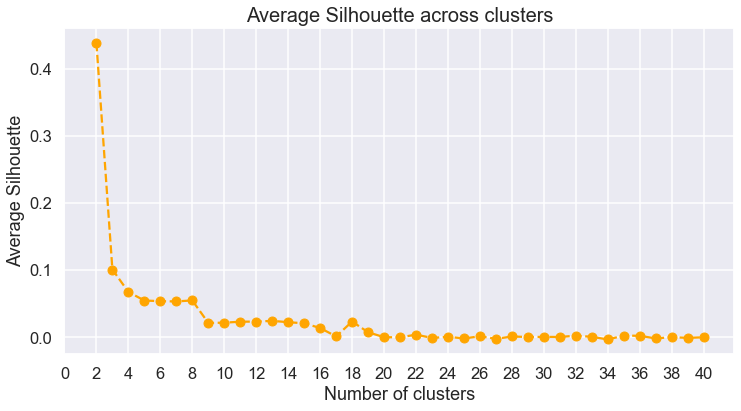

In [82]:
plot_score(doseall_silh_score, 'Average Silhouette')

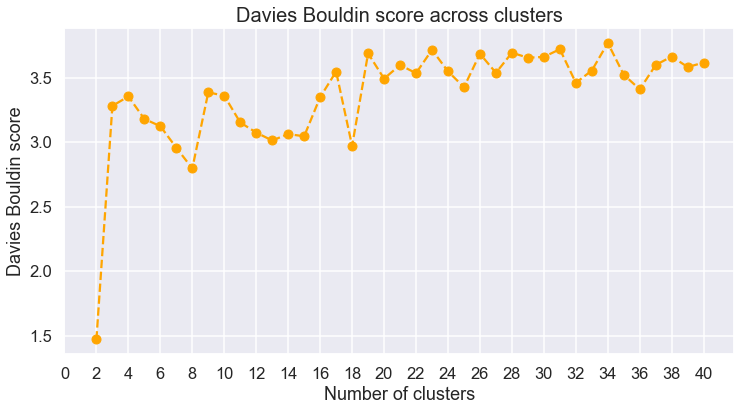

In [83]:
plot_score(doseall_davie_score, 'Davies Bouldin score')

In [84]:
def plot_pca_var(pca, pc_num):
    
    #plt.rcParams.update({'font.size': 12})
    plt.figure(figsize = (16, 10))
    df_var = pd.DataFrame({'var':pca.explained_variance_ratio_, 'PC':['PC' + str(x) for x in range(1,pc_num+1)]})
    df_var['var'] = df_var['var'] * 100
    #sns.barplot(x='PC',y="var", data=df_var, color="c")
    plt.bar(df_var['PC'], df_var['var'], color ='c')
    plt.xlim(0, pc_num+1)
    plt.ylabel('Explained Variance %')
    plt.xlabel('Principal Components')
    plt.xticks(np.arange(0, pc_num, step=50))
    plt.title("Amount of variance explained by each Principal component for Cell painting level-4 profiles")
    ##plt.savefig('cluster_images/var_exp_PCA.png')
    plt.show()
    
    return df_var

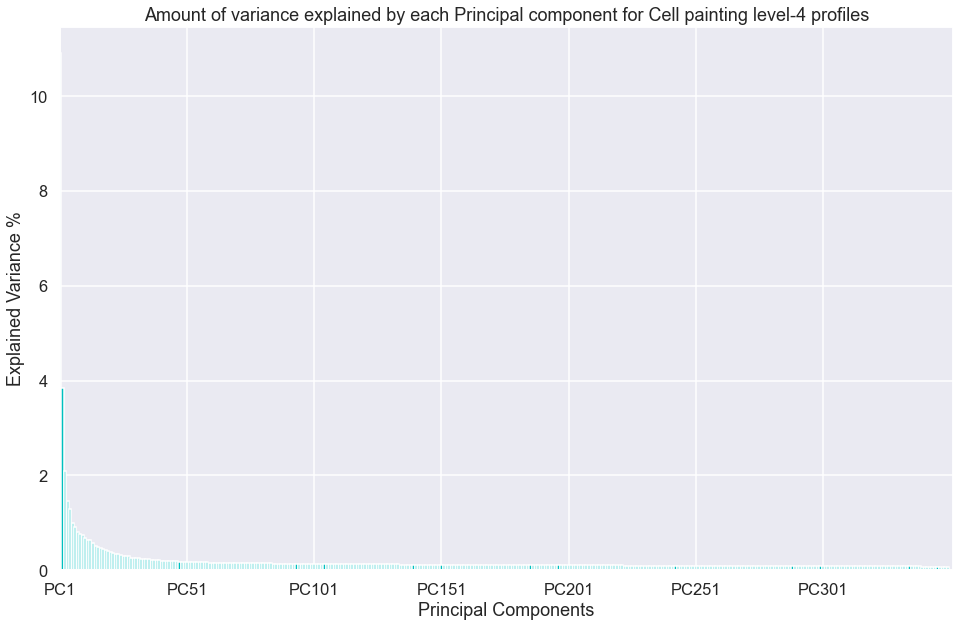

In [85]:
df_var_full = plot_pca_var(pca_all, 350)

In [86]:
def save_to_csv(df, path, file_name, compress=None):
    """saves dataframes to csv"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    df.to_csv(os.path.join(path, file_name), index=False, compression=compress)

In [87]:
silh_list = [df_silh1, df_silh2, df_silh3, df_silh4, df_silh5, df_silh6, df_silhall]
db_list = [df_db1, df_db2, df_db3, df_db4, df_db5, df_db6, df_dball]  # List of your dataframes
bic_list = [df_bic1, df_bic2, df_bic3, df_bic4, df_bic5, df_bic6]  # List of your dataframes
df_bic = pd.concat(bic_list, ignore_index=True)
df_silh = pd.concat(silh_list, ignore_index=True)
df_db = pd.concat(db_list, ignore_index=True)

In [88]:
save_to_csv(df_silh, L1000_level4_path, 'L1000_silhouette_scores.csv')
save_to_csv(df_db, L1000_level4_path, 'L1000_db_scores.csv')
save_to_csv(df_bic, L1000_level4_path, 'L1000_bic_scores.csv')
save_to_csv(df_var_full, L1000_level4_path, 'L1000_pca_explained_variance.csv')